In [5]:
import spacy
import string

def clean_text(corpus):
    # Remove punctuations from the corpus
    translator = str.maketrans('', '', string.punctuation)
    corpus = corpus.translate(translator)

    # Remove digits from the corpus
    remove_digits = str.maketrans('', '', string.digits)
    corpus = corpus.translate(remove_digits)
    return corpus



with open("scripts_concat.txt", "r") as f:
    scripts_string = f.read()

corpus = clean_text(scripts_string)

nlp = spacy.load('en_core_web_sm')


print("Tamaño del corpus: {}".format(len(corpus)))
print("nlp max length: {}".format(nlp.max_length))

corpus_chunk = [corpus[i:i+nlp.max_length] for i in range (0,len(corpus), nlp.max_length)]


# we process chunks of the corpus accoding to the max length of nlp

docs = []
for chunk in corpus_chunk:
    doc = nlp(chunk)
    docs.append(doc)



Tamaño del corpus: 4740654
nlp max length: 1000000


# Análisis del texto

In [6]:
words = []
nouns = []
verbs = []
people = []
orgs = []

for doc in docs:
    for token in doc:
        words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)
            
        if token.pos_ == "NOUN":
            nouns.append(token.text)


for doc in docs:
    for ent in doc.ents:
        if ent.label_ == "ORG":
            orgs.append(ent.text)
        if ent.label_ == "PERSON":
            people.append(ent.text)

print("Total words: ", len(words))
print("Total verbs: ", len(verbs))
print("Total nouns: ", len(nouns))
print("Total people: ", len(people))
print("Total organizations: ", len(orgs))

Total words:  656598
Total verbs:  88254
Total nouns:  85804
Total people:  17500
Total organizations:  6215


## Contando palabras

In [7]:
from collections import Counter
from collections import OrderedDict

def sort_by_frequency(data,reverse=True):
    """ 
    Function to sord the data by its frequency
    Returns ordered dictionary
    Default: Sort in descending order
        
    """
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))
    
    return data_sorted_by_freq

words_frequency = sort_by_frequency(words)
nouns_frequency = sort_by_frequency(nouns)
verbs_frequency  = sort_by_frequency(verbs)
people_frequency = sort_by_frequency(people)
orgs_frequency = sort_by_frequency(orgs)

#print(verbs_frequency)

# Analizando Bigramas

In [13]:
import nltk

def create_bigram(tokens):
    # Using words token generated from spacy to find bigram
    bigrams_ = list(nltk.bigrams(tokens))
    # Convert generator into list of tuples of bigram 
    bigrams = [" ".join(bigram) for bigram in list(bigrams_)]

    return bigrams

bigrams = create_bigram(words)

def get_racist_bigrams(bigrams):
    with open("racist_slang.txt", "r") as f:
        racist_slang_list = f.read().split("\n")
    
    racist_bigrams = []
    for bigram in bigrams:
        if any(word in bigram for word in racist_slang_list):
            racist_bigrams.append(bigram)
    
    return racist_bigrams



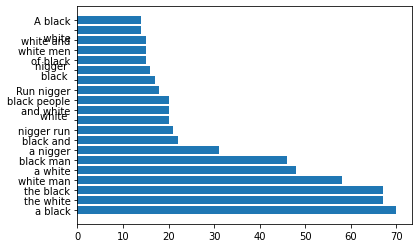

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def get_top_n_from_order_dict(ordered_dict,n):
    """ Function to find n top object from ordered dictionary"""
    return [list(ordered_dict.items())[i] for i in range(n)]


def visualize_list_of_tuple(data):
    """"""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center' )
    plt.yticks(y_pos, list1)
    plt.show()

top_racist_bigrams = get_top_n_from_order_dict(sort_by_frequency(get_racist_bigrams(bigrams)) , 20)
# The most popular rascist slurs
visualize_list_of_tuple(top_racist_bigrams)

# Clustering

## Clustering con monogramas

In [21]:
import spacy
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter



NUM_CLUSTERS = 10

# funcion para normalizar el oraciones


def normalize_sentence(span):
    # sacamos stopwords y signos de puntuación
    words = [t for t in span if not t.is_punct | t.is_stop]
    # nos quedamos con tokens alfabéticos y con largo considerable
    lexical_tokens = [t for t in words if len(t.orth_) > 3 and
                      t.orth_.isalpha()]

    # removemos pronombres
    cleaned_lemmas = [tok.lemma_.lower()
                      for tok in lexical_tokens if tok.pos_ != 'PRON']

    return cleaned_lemmas


def show_results(vocabulary, model):
    # Show results
    c = Counter(sorted(model.labels_))
    print("\nTotal clusters:", len(c))
    for cluster in c:
        print("Cluster#", cluster, " - Total words:", c[cluster])

    # Show top terms and words per cluster
    print("Top words per cluster:")
    print()

    keysVocab = list(vocabulary.keys())
    for n in range(len(c)):
        print("Cluster %d" % n)
        print("Words:", end='')
        word_indexs = [i for i, x in enumerate(list(model.labels_)) if x == n]
        for i in word_indexs:
            print(' %s' % keysVocab[i], end=',')
        print()
        print()

    print()



lemmatized_sentences = []

for doc in docs:
    for span in doc.sents:
        lemmatized_sentences.append(normalize_sentence(span))


# entrenamos un modelo de word embeddings neuronales
model = Word2Vec(lemmatized_sentences, min_count=1)
vocabulary = model.wv.key_to_index

# vectores que conseguimos del modelo
vectors = []
for word in vocabulary:
    vectors.append(model.wv[word])

matrix = np.array(vectors)
print("Matrix shape:", matrix.shape)

# normalizamos matriz y reducimos dimensionalidad quitando columnas con poca varianza

matrix_normed = matrix / matrix.max(axis=0)

variances = np.square(matrix_normed).mean(axis=0) - \
    np.square(matrix_normed.mean(axis=0))
VarianzaMin = 0.001
red_matrix = np.delete(matrix_normed, np.where(
    variances < VarianzaMin), axis=1)


# Utilizamos el algoritmo de K-means de scikit-learn
k_means_model = KMeans(n_clusters=NUM_CLUSTERS, init = "k-means++",max_iter=150,n_init=1)
k_means_model.fit(red_matrix)


#show_results(vocabulary, k_means_model)

Matrix shape: (18771, 100)


KMeans(max_iter=150, n_clusters=10, n_init=1)

## Clustering sobre scripts completos

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import time
from sklearn.cluster import KMeans




class DocumentCluster:
    """Class to cluster document"""
    def __init__(self,model,data,labels):
        self.model = model
        self.data = data
        self.labels = labels
        self.model_name = self._get_model_name()
        
        self.cluster_pipeline = None
        
    
    def _get_model_name(self):
        """Get name of model being used"""
        model_name = str(self.model).split('(')[0]
        return model_name
            

    
    def train_model(self,ngram,use_idf):
        """ 
            Train model
            ngram: int
            use_idf: bool
            analyzer: string
        
        """
        current_time = time.time()
        self._ngram = ngram
        self._use_idf = use_idf
        
        # Set a pipeline
        # 1. The first step of the pipeline is to find count vectorizer
        # Countvectorizer converts a collection of text documents to a matrix of token counts
        # This implementation produces a sparse representation of the counts
        # 2. We then use TfidfTransformr
        # TfidfTransformer transforms a count matrix to a normalized tf or tf-idf representation
        # Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency

        self.cluster_pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1,ngram), 
                analyzer="word")), ('tfidf', TfidfTransformer(use_idf=use_idf)), 
                ('model', self.model)])
        self._cluster = self.cluster_pipeline.fit(self.data)
        
        self._train_time = time.time() - current_time
        
        
        print("Training completed")
        print("Training time for {} : {} secs".format(self.model_name, self._train_time))
        
    
    def predict(self):
        """
        Predict cluster id for all clusters
        """
        self.label_id_dict = {}
        self.document_id_dict = {}
        self.cluster_id = []
        for i, document in enumerate(self.data):
            cluster_id = self.cluster_pipeline.predict([document])[0]
            self.label_id_dict.update({self.labels[i]:cluster_id})
            self.document_id_dict.update({document:cluster_id})
            self.cluster_id.append(cluster_id)
        
        return self.label_id_dict, self.document_id_dict

In [8]:
import json

with open("movies_scripts.json", "r") as f:
    data = json.load(f)

docs_text = list(map(lambda d: d["script"], data.values()))
labels = list(data.keys()) # the labels of each doc it's the name of the movie

cleaned_docs = []
for d in docs_text:
    cleaned_docs.append(clean_text(d).lower())


In [10]:
cluster_num = 5
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

doc_cluster = DocumentCluster(data=cleaned_docs,model=model,labels=labels)

doc_cluster.train_model(ngram=2, use_idf=True)

result_label, result_docs = doc_cluster.predict()


result_label

Training completed
Training time for KMeans : 1.876147747039795 secs


{'gran torino': 4,
 'american history x': 1,
 'blackkklansman': 1,
 'School ties': 1,
 'race': 1,
 '42': 1,
 'django': 1,
 'red tails': 1,
 'the green mile': 1,
 'white chicks': 1,
 'glory road': 1,
 'ali': 1,
 'a time to kill': 1,
 'malcolm x': 1,
 'finding forrester': 2,
 'black cop': 1,
 'get out': 1,
 'Do the Right Thing': 1,
 'Fruitvale Station': 0,
 '12 Years a Slave': 1,
 'Born on the Fourth of July': 1,
 'forrest gump': 3,
 'Gangs of New York Script': 1}

In [14]:

# grouping texts by cluster

clusters_text = []
for i in range(cluster_num):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)


# obteniendo los bigramas donde hay insinuaciones racistas 

def get_cluster_analysis_results(clusters_text):
    racist_bigrams_per_cluster = []
    for i, corpus in enumerate(clusters_text):
        tokens = corpus.split()
        bigrams = create_bigram(tokens)
        racist_bigrams_per_cluster.append(sort_by_frequency(get_racist_bigrams(bigrams)))



    return racist_bigrams_per_cluster

racist_bigrams_per_cluster = get_cluster_analysis_results(clusters_text)


for i in range(cluster_num):
    print("cluster {}".format(i))
    print(racist_bigrams_per_cluster[i])




cluster 0
OrderedDict([('a black', 11), ('black woman', 8), ('a white', 6), ('ass nigga', 5), ('black man', 3), ('my nigga', 3), ('old black', 2), ('white girl', 2), ('with white', 2), ('nigga sophina', 2), ('these niggas', 2), ('white man', 2), ('nigga huh', 2), ('looking black', 1), ('beautiful black', 1), ('charismatic black', 1), ('black male', 1), ('older black', 1), ('he black', 1), ('black katie', 1), ('hes white', 1), ('white but', 1), ('of black', 1), ('black people', 1), ('white collared', 1), ('white people', 1), ('black card', 1), ('black barber', 1), ('small white', 1), ('white bandage', 1), ('stocky white', 1), ('white inmate', 1), ('white boy', 1), ('birthday nigga', 1), ('ceephus black', 1), ('black uniforms', 1), ('uniforms black', 1), ('black players', 1), ('players black', 1), ('black coach', 1), ('black wife', 1), ('white rice', 1), ('black guy', 1), ('all white', 1), ('white dudes', 1), ('black face', 1), ('niggas brought', 1), ('nigga we', 1), ('nigga brandon', 1)

# Clustering sobre diálogos de los scripts

In [17]:
lines = []
labels = []

for doc in docs:

    for tuple in enumerate(doc.sents):
        lines.append(tuple[1].text)
        labels.append(tuple[0])

cluster_num = 5
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

doc_cluster = DocumentCluster(data=lines,model=model,labels=labels)

doc_cluster.train_model(ngram=2, use_idf=True)

result_label, result_docs = doc_cluster.predict()




Training completed
Training time for KMeans : 2.6837081909179688 secs


In [18]:
# grouping texts by cluster

clusters_text = []
for i in range(cluster_num):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)


# obteniendo los bigramas donde hay insinuaciones racistas 

def get_cluster_analysis_results(clusters_text):
    racist_bigrams_per_cluster = []
    for i, corpus in enumerate(clusters_text):
        tokens = corpus.split()
        bigrams = create_bigram(tokens)
        racist_bigrams_per_cluster.append(sort_by_frequency(get_racist_bigrams(bigrams)))



    return racist_bigrams_per_cluster


racist_bigrams_per_cluster = get_cluster_analysis_results(clusters_text)



for i in range(cluster_num):
    print("cluster {}".format(i))
    print(len(racist_bigrams_per_cluster[i]))
    print(racist_bigrams_per_cluster[i])




cluster 0
485
OrderedDict([('a black', 21), ('a nigger', 19), ('white man', 11), ('a white', 6), ('of black', 6), ('white folks', 5), ('black man', 4), ('with white', 4), ('A black', 4), ('were black', 4), ('black people', 4), ('black and', 3), ('A nigger', 3), ('niggers and', 3), ('black hole', 3), ('goes white', 3), ('white boys', 3), ('little white', 3), ('no white', 3), ('like white', 3), ('niggers are', 3), ('that nigger', 3), ('a niggers', 3), ('white people', 3), ('A white', 3), ('ass nigga', 3), ('nigger that', 3), ('this white', 2), ('white devil', 2), ('on white', 2), ('nigger on', 2), ('the nigger', 2), ('nigger in', 2), ('were white', 2), ('Yankee Stadium', 2), ('Hey black', 2), ('black boy', 2), ('white boy', 2), ('these white', 2), ('your nigger', 2), ('nigger gals', 2), ('other niggers', 2), ('niggers around', 2), ('white men', 2), ('kill white', 2), ('black slaver', 2), ('nigger fight', 2), ('the white', 2), ('niggers ass', 2), ('a nigga', 2), ('this nigger', 2), ('nigg

# Contextos indicadores de racismo usando Información mutua

In [19]:
with open("scripts_concat.txt", "r") as f:
    scripts_string = f.read()

corpus = clean_text(scripts_string)

corpus_chunk = [corpus[i:i+nlp.max_length] for i in range (0,len(corpus), nlp.max_length)]

docs = []
for chunk in corpus_chunk:
    doc = nlp(chunk)
    docs.append(doc)


In [20]:
racist_seeds = []

with open("racist_slang.txt", "r") as f:
    s = f.read()

racist_seeds = set(s.split("\n"))


In [21]:
movie_lines = [] # it contains all the lines of the scripts
racist_lines = [] # it contains the context of a racist line and the racist line
racist_indexes = []

for doc in docs:
    for sent in doc.sents:
        movie_lines.append(sent.text)
        if len(racist_seeds.intersection( set(sent.text.split(" "))  )) != 0:
            
            # we keep the context of the racist lines
            racist_lines.append(sent.text)
            racist_lines.append(movie_lines[-2])
            racist_lines.append(movie_lines[-3])
            racist_indexes.append(len(movie_lines) - 1)

# we obtain the next two lines of dialogue of a racist one
for i in racist_indexes:
    racist_lines.append(movie_lines[i+1])
    racist_lines.append(movie_lines[i+2])



word_count_racist_context = sort_by_frequency("".join(racist_lines).split())
word_count_total = sort_by_frequency("".join(movie_lines).split())


In [22]:
from numpy import log2

def imp(num_ocur_rac_context, num_ocur_total):
    amount_words_rc = sum(map(lambda s: len(s.split()), racist_lines))

    return log2(num_ocur_rac_context / (num_ocur_total * amount_words_rc))

for rk in word_count_racist_context.keys():
    if rk in word_count_total.keys():
        print("Palabra: {} - IMP: {}".format(rk, imp(word_count_racist_context[rk], word_count_total[rk])))



Palabra: the - IMP: -18.855306644149376
Palabra: a - IMP: -18.785084157176122
Palabra: and - IMP: -18.762365238257228
Palabra: to - IMP: -19.100163211086645
Palabra: of - IMP: -18.74515399355086
Palabra: in - IMP: -18.84798749737054
Palabra: you - IMP: -19.18073022775289
Palabra: is - IMP: -18.782393292018913
Palabra: his - IMP: -18.95941262071216
Palabra: black - IMP: -15.840791028750898
Palabra: I - IMP: -19.610605603900357
Palabra: on - IMP: -19.13789514168163
Palabra: with - IMP: -18.79562600854924
Palabra: white - IMP: -15.7555468904254
Palabra: that - IMP: -18.924490154251103
Palabra: The - IMP: -19.147362455064407
Palabra: it - IMP: -19.501906474973303
Palabra: as - IMP: -18.858081085766358
Palabra: are - IMP: -18.6501377984822
Palabra: he - IMP: -19.015436323850594
Palabra: at - IMP: -19.28275839995415
Palabra: for - IMP: -19.082272189557056
Palabra: up - IMP: -19.156488889726443
Palabra: He - IMP: -19.080952394940887
Palabra: from - IMP: -18.754207355784036
Palabra: man - IMP: